# **Opera Data science Assignment**
Experiment was conducted to evaluate the impact of displaying a hint message to Opera browser users. The hint message aimed to inform users about a new feature, referred to as "m," recently added to the browser.

- The experiment randomly divided users into five groups:
  - **Control Group**: Users who did not see any hint (reference group).
  - **Test Groups**: Users who were shown one of four different versions of the hint message.
    - `DNA-XYZ-big-header`
    - `DNA-XYZ-big-header-sidebar`
    - `DNA-XYZ-subheader`
    - `DNA-XYZ-subheader-sidebar`
- Users could react to the hint in three ways:
  - **Accept**: Engage with the hint by clicking to explore the feature.
  - **Dismiss**: Ignore the hint for the time being.
  - **Don't Show Again**: Opt out of seeing the hint in the future.

#### **Primary Metrics**
- **`m_clicks_total`**: Total number of clicks on the feature (main indicator of user engagement).
#### **Secondary Metrics**
- **`m_used_days`**: Number of days the feature was used by the user.
- **`days_in_test`**: Duration of user participation in the experiment.
- **Hint Responses**:
  - **`m_hints_accepted`**: Number of times the hint was accepted.
  - **`m_hints_dismissed`**: Number of times the hint was dismissed.
  - **`m_hints_dont_show`**: Number of times the user chose not to see the hint again.
#### **Other Features**
- **`fst_hint_day`**: The first day the user saw the hint.
- **`is_hinted`**: Indicates whether the user received a hint (1 = Yes, 0 = No).
- **`test_group`**: The group to which the user belongs (control or one of the four test groups).
- **`country`**: The country of the user.

#### **Objectives:**
1. **`Data Exploration and Data cleaning`**
2. **`Interpretation of Data Exploration`**
3. **`A/B Testing and Statistical Analysis`**
4. **`Key Findings and Conclusions`**

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm, beta
from IPython.display import display

### **1. Data Exploration and Data cleaning**

In [2]:
# Load the datasets and relavent sheets
data_path = r"C:/Users/ishii/Documents/Opera_AB_Testing/ab-test-homework-data.xlsx"
data = pd.ExcelFile(data_path)

description = data.parse("Descrpiton and task")
dataset = data.parse("InApp_data")

In [3]:
# Basic information about the dataset
print("Dataset Info:")
print(dataset.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4092 entries, 0 to 4091
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         4092 non-null   int64  
 1   country            4092 non-null   object 
 2   test_group         4092 non-null   object 
 3   small_huid         4092 non-null   int64  
 4   age0               4092 non-null   int64  
 5   m_clicks_total     4092 non-null   int64  
 6   m_used_days        4092 non-null   int64  
 7   m_click_w1         4092 non-null   int64  
 8   m_click_w2         4092 non-null   int64  
 9   days_in_test       4092 non-null   int64  
 10  fst_hint_day       3294 non-null   float64
 11  m_hints_accepted   4092 non-null   int64  
 12  m_hints_dismissed  4092 non-null   int64  
 13  m_hints_dont_show  4092 non-null   int64  
 14  is_hinted          4092 non-null   int64  
dtypes: float64(1), int64(12), object(2)
memory usage: 479.7+ K

In [4]:
missing_values = dataset.isnull().sum()
print("\nMissing Values:")
print(missing_values)


Missing Values:
Unnamed: 0             0
country                0
test_group             0
small_huid             0
age0                   0
m_clicks_total         0
m_used_days            0
m_click_w1             0
m_click_w2             0
days_in_test           0
fst_hint_day         798
m_hints_accepted       0
m_hints_dismissed      0
m_hints_dont_show      0
is_hinted              0
dtype: int64


In [6]:
# Verify test group assignments
print("\nUnique test groups:")
print(dataset['test_group'].unique())


Unique test groups:
['DNA-XYZ-big-header' 'DNA-XYZ-big-header-sidebar' 'DNA-XYZ-ref'
 'DNA-XYZ-subheader' 'DNA-XYZ-subheader-sidebar']


In [5]:
# Since `fst_hint_day` is missing only for non-hinted users, we'll confirm this relationship
non_hinted_missing = dataset[(dataset["is_hinted"] == 0) & (dataset["fst_hint_day"].isnull())]
hinted_non_missing = dataset[(dataset["is_hinted"] == 1) & (~dataset["fst_hint_day"].isnull())]

# Print counts for verification
print(f"Non-hinted users with missing `fst_hint_day`: {len(non_hinted_missing)}")
print(f"Hinted users with non-missing `fst_hint_day`: {len(hinted_non_missing)}")
print(f"Total non-hinted users: {dataset['is_hinted'].value_counts()[0]}")
print(f"Total hinted users: {dataset['is_hinted'].value_counts()[1]}")

# Check alignment without assertion
if len(non_hinted_missing) != dataset["is_hinted"].value_counts()[0]:
    print("Warning: Some non-hinted users may have non-missing `fst_hint_day` values!")
if len(hinted_non_missing) != dataset["is_hinted"].value_counts()[1]:
    print("Warning: Some hinted users may hav")

Non-hinted users with missing `fst_hint_day`: 798
Hinted users with non-missing `fst_hint_day`: 3292
Total non-hinted users: 800
Total hinted users: 3292


**Discrepancy**
- The total non-hinted user count is 800, but only 798 have `fst_hint_day` missing.
- This implies that 2 non-hinted users have a non-missing `fst_hint_day`, which is unexpected because non-hinted users should not have a hint day.

In [44]:
anomalous_users = dataset[(dataset["is_hinted"] == 0) & (~dataset["fst_hint_day"].isnull())]
display(anomalous_users)

,Unnamed: 0,country,test_group,small_huid,age0,m_clicks_total,m_used_days,m_click_w1,m_click_w2,days_in_test,fst_hint_day,m_hints_accepted,m_hints_dismissed,m_hints_dont_show,is_hinted,engagement_rate
3292,3292,IN,DNA-XYZ-ref,842,0,0,0,0,0,7,0.0,0,0,0,0,0.0
3293,3293,GB,DNA-XYZ-ref,2589,0,0,0,0,0,2,0.0,0,0,0,0,0.0
3294,3294,IN,DNA-XYZ-ref,3804,0,0,0,0,0,1,0.0,0,0,0,0,0.0
3295,3295,IN,DNA-XYZ-ref,1328,0,0,0,0,0,2,0.0,0,0,0,0,0.0
3296,3296,GB,DNA-XYZ-ref,4052,0,0,0,0,0,4,0.0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4087,4087,IN,DNA-XYZ-ref,1116,0,0,0,0,0,3,0.0,0,0,0,0,0.0
4088,4088,GB,DNA-XYZ-ref,2269,0,0,0,0,0,3,0.0,0,0,0,0,0.0
4089,4089,US,DNA-XYZ-ref,3421,0,0,0,0,0,2,0.0,0,0,0,0,0.0
4090,4090,GB,DNA-XYZ-ref,3974,0,0,0,0,0,1,0.0,0,0,0,0,0.0


Since both users belong to the control group `DNA-XYZ-ref` and should not have a fst_hint_day, it is most logical to correct their fst_hint_day values to 0. This ensures that all control group members are treated consistently.

In [43]:
# Set `fst_hint_day` to 0 for anomalous users
dataset.loc[(dataset["is_hinted"] == 0) & (~dataset["fst_hint_day"].isnull()), "fst_hint_day"] = 0

# Verify the fix
display(dataset[(dataset["is_hinted"] == 0) & (~dataset["fst_hint_day"].isnull())])

,Unnamed: 0,country,test_group,small_huid,age0,m_clicks_total,m_used_days,m_click_w1,m_click_w2,days_in_test,fst_hint_day,m_hints_accepted,m_hints_dismissed,m_hints_dont_show,is_hinted,engagement_rate
3292,3292,IN,DNA-XYZ-ref,842,0,0,0,0,0,7,0.0,0,0,0,0,0.0
3293,3293,GB,DNA-XYZ-ref,2589,0,0,0,0,0,2,0.0,0,0,0,0,0.0
3294,3294,IN,DNA-XYZ-ref,3804,0,0,0,0,0,1,0.0,0,0,0,0,0.0
3295,3295,IN,DNA-XYZ-ref,1328,0,0,0,0,0,2,0.0,0,0,0,0,0.0
3296,3296,GB,DNA-XYZ-ref,4052,0,0,0,0,0,4,0.0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4087,4087,IN,DNA-XYZ-ref,1116,0,0,0,0,0,3,0.0,0,0,0,0,0.0
4088,4088,GB,DNA-XYZ-ref,2269,0,0,0,0,0,3,0.0,0,0,0,0,0.0
4089,4089,US,DNA-XYZ-ref,3421,0,0,0,0,0,2,0.0,0,0,0,0,0.0
4090,4090,GB,DNA-XYZ-ref,3974,0,0,0,0,0,1,0.0,0,0,0,0,0.0


In [9]:
# Fill missing `fst_hint_day` values with 0
dataset["fst_hint_day"] = dataset["fst_hint_day"].fillna(0)

In [10]:
# Ensure `m_clicks_total`, `m_used_days`, and related metrics have consistent ranges
dataset = dataset[(dataset['m_clicks_total'] >= 0) & (dataset['m_used_days'] >= 0)]

In [11]:
# Derive additional metrics if needed (e.g., engagement rate: `m_clicks_total` per `days_in_test`)
dataset['engagement_rate'] = dataset['m_clicks_total'] / dataset['days_in_test']
dataset['engagement_rate'] = dataset['engagement_rate'].fillna(0)

In [12]:
# Summarize the cleaned data
print("\nData cleaning completed. Here's a quick summary of the cleaned data:")
print(dataset.describe())


Data cleaning completed. Here's a quick summary of the cleaned data:
       Unnamed: 0  small_huid         age0  m_clicks_total  m_used_days  \
count  4092.00000  4092.00000  4092.000000     4092.000000  4092.000000   
mean   2045.50000  2045.50000   103.310362       11.333089     0.980938   
std    1181.40298  1181.40298   260.911192       60.088619     2.295698   
min       0.00000     0.00000     0.000000        0.000000     0.000000   
25%    1022.75000  1022.75000     0.000000        0.000000     0.000000   
50%    2045.50000  2045.50000     0.000000        0.000000     0.000000   
75%    3068.25000  3068.25000    42.250000        1.000000     1.000000   
max    4091.00000  4091.00000  2189.000000      700.000000    14.000000   

        m_click_w1   m_click_w2  days_in_test  fst_hint_day  m_hints_accepted  \
count  4092.000000  4092.000000   4092.000000   4092.000000       4092.000000   
mean      0.262708     0.161779      9.256843      4.357527          0.228006   
std       0

In [13]:
# Group data by `test_group` and calculate metrics
summary = dataset.groupby("test_group")[
    ["m_clicks_total", "m_used_days", "days_in_test"]
].agg(["mean", "std", "count"])
print("\nGroup Summary:")
print(summary)


Group Summary:
                           m_clicks_total                  m_used_days  \
                                     mean        std count        mean   
test_group                                                               
DNA-XYZ-big-header              14.197590  65.509634   830    1.221687   
DNA-XYZ-big-header-sidebar      15.858974  73.911150   780    1.296154   
DNA-XYZ-ref                      2.299885  31.237488   867    0.209919   
DNA-XYZ-subheader               13.524051  64.736387   790    1.148101   
DNA-XYZ-subheader-sidebar       11.567273  57.337450   825    1.090909   

                                           days_in_test                  
                                 std count         mean       std count  
test_group                                                               
DNA-XYZ-big-header          2.525434   830    10.739759  3.322582   830  
DNA-XYZ-big-header-sidebar  2.636416   780    10.603846  3.338150   780  
DNA-XYZ-ref          


Correlation Matrix:
                    age0  days_in_test  m_clicks_total  m_used_days
age0            1.000000      0.154311       -0.006245    -0.052011
days_in_test    0.154311      1.000000        0.120723     0.187699
m_clicks_total -0.006245      0.120723        1.000000     0.745836
m_used_days    -0.052011      0.187699        0.745836     1.000000


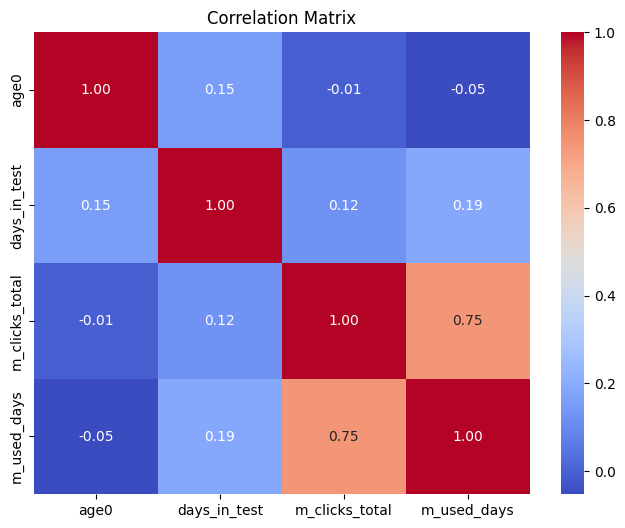

In [14]:
# Correlation Analysis
correlation_matrix = dataset[
    ["age0", "days_in_test", "m_clicks_total", "m_used_days"]
].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)

# Visualize correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

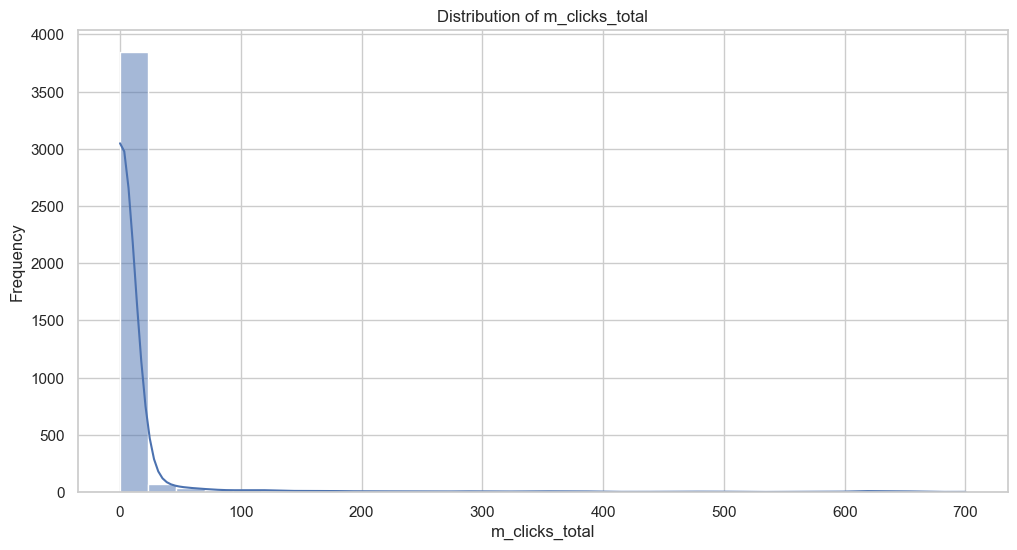

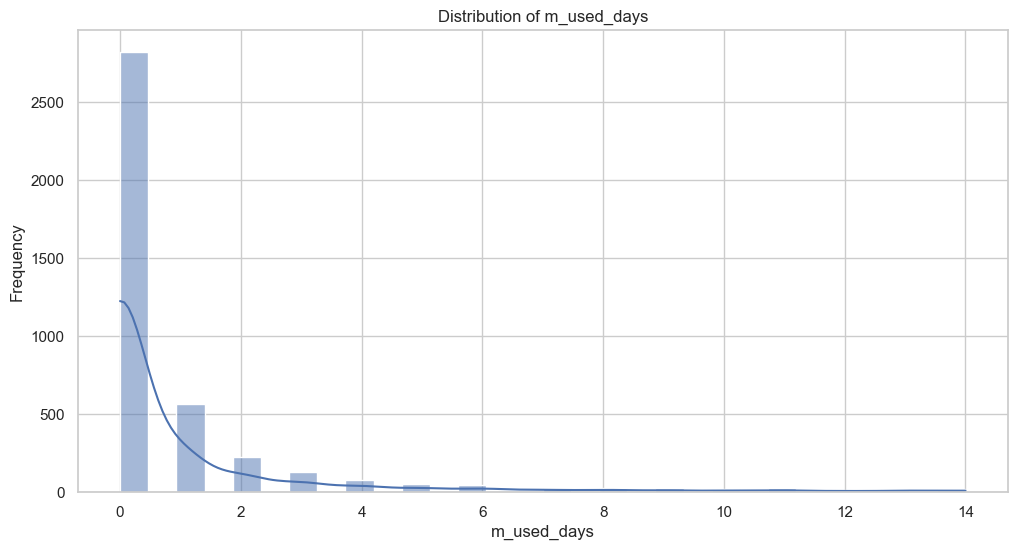

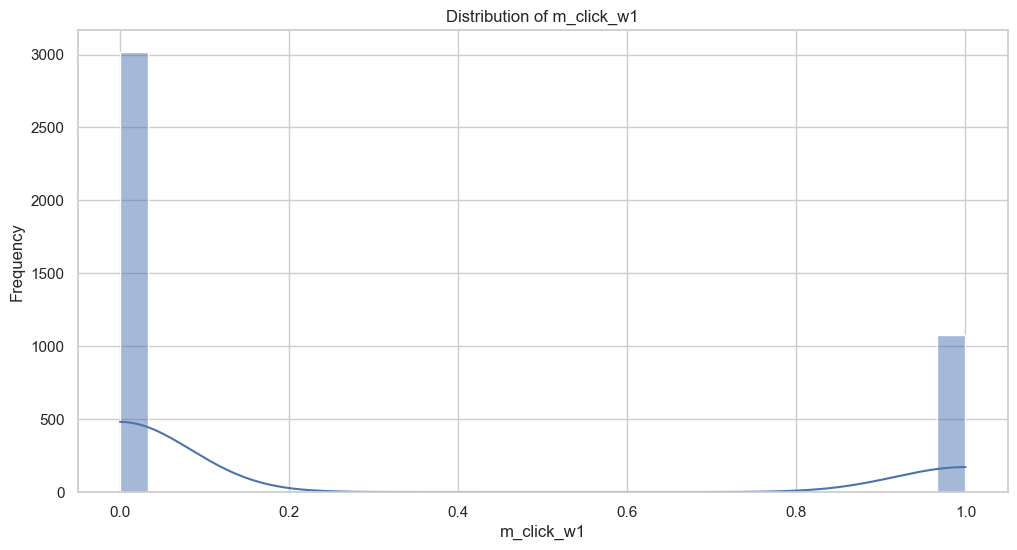

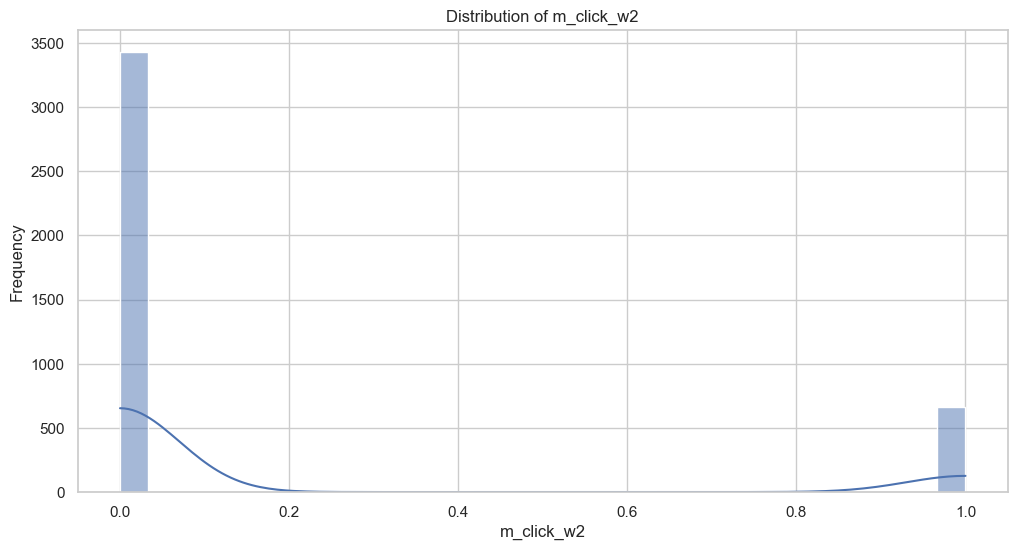

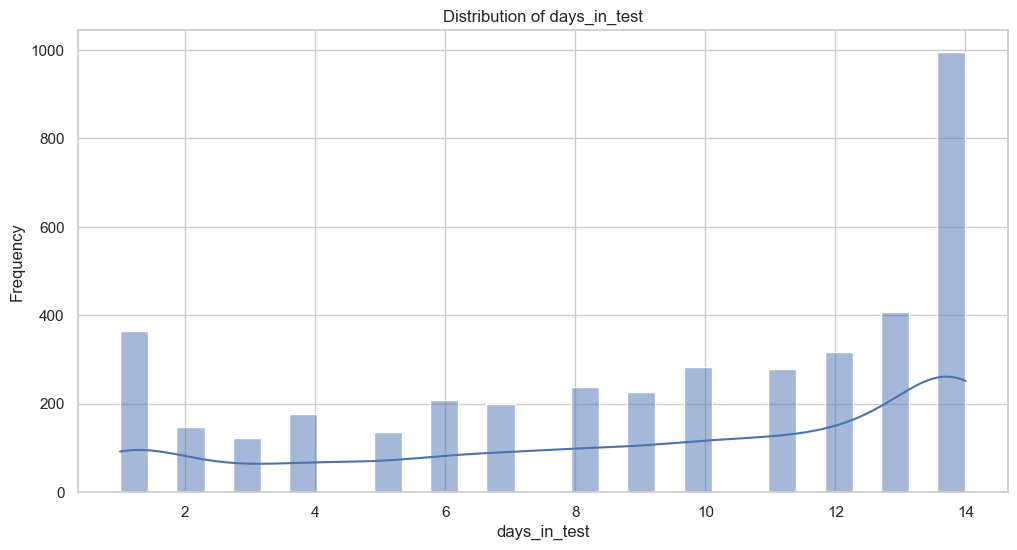

C:\Users\ishii\AppData\Local\Temp\ipykernel_22600\3805128833.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataset[col], palette="Blues")


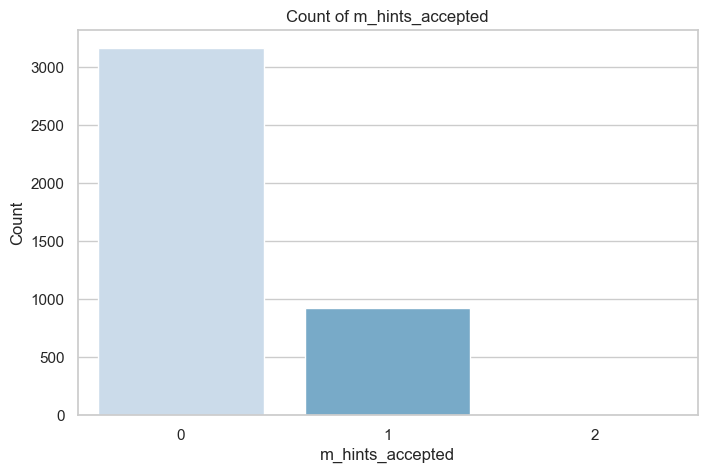

C:\Users\ishii\AppData\Local\Temp\ipykernel_22600\3805128833.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataset[col], palette="Blues")


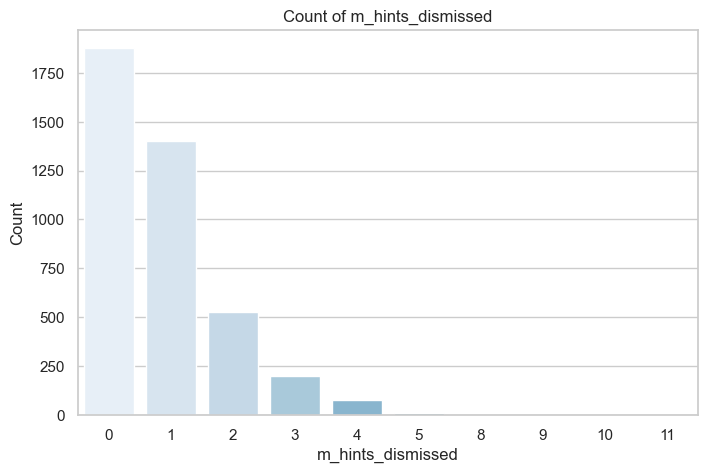

C:\Users\ishii\AppData\Local\Temp\ipykernel_22600\3805128833.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataset[col], palette="Blues")


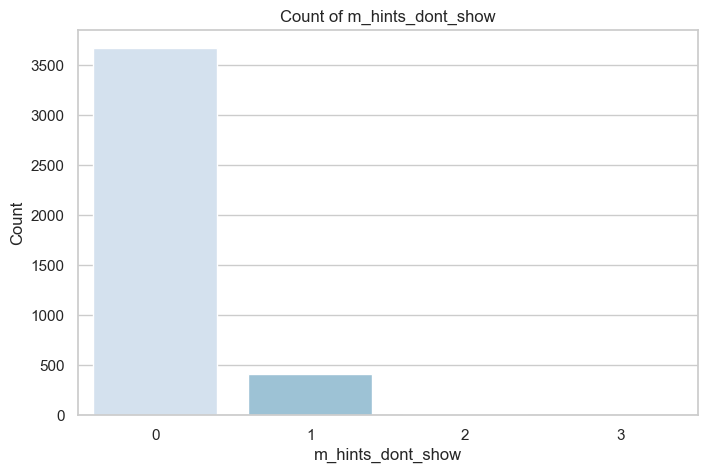

In [15]:
# Set plot style
sns.set(style="whitegrid")

# List of numeric columns to visualize
columns_to_plot = ["m_clicks_total", "m_used_days", "m_click_w1", "m_click_w2", "days_in_test"]

# Plot histograms for the selected columns
for col in columns_to_plot:
    plt.figure(figsize=(12, 6))
    sns.histplot(dataset[col], bins=30, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# Hint interaction metrics (categorical data)
hint_columns = ["m_hints_accepted", "m_hints_dismissed", "m_hints_dont_show"]

# Plot count plots for hint interactions
for col in hint_columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=dataset[col], palette="Blues")
    plt.title(f"Count of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

In [16]:
# Outlier Analysis
# Using IQR to detect outliers in `m_clicks_total`
Q1 = dataset["m_clicks_total"].quantile(0.25)
Q3 = dataset["m_clicks_total"].quantile(0.75)
IQR = Q3 - Q1
outliers = dataset[(dataset["m_clicks_total"] < (Q1 - 1.5 * IQR)) | (dataset["m_clicks_total"] > (Q3 + 1.5 * IQR))]
print(f"\nNumber of Outliers in m_clicks_total: {len(outliers)}")


Number of Outliers in m_clicks_total: 702


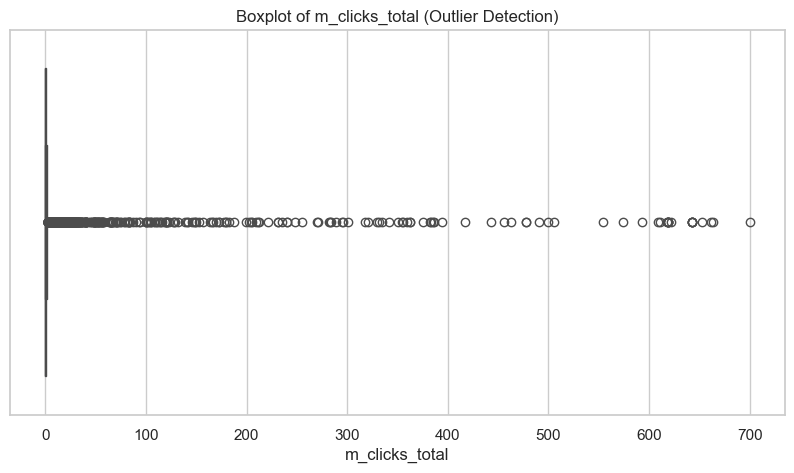

In [17]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=dataset["m_clicks_total"])
plt.title("Boxplot of m_clicks_total (Outlier Detection)")
plt.show()

In [42]:
display(outliers[['m_clicks_total', 'test_group', 'is_hinted']].sort_values(by="m_clicks_total", ascending=False).head(10))

,m_clicks_total,test_group,is_hinted
1012,700,DNA-XYZ-big-header,1
1245,663,DNA-XYZ-big-header-sidebar,1
311,661,DNA-XYZ-big-header-sidebar,1
2003,653,DNA-XYZ-subheader-sidebar,1
1077,643,DNA-XYZ-big-header,1
1837,643,DNA-XYZ-subheader,1
2223,643,DNA-XYZ-subheader-sidebar,1
1598,643,DNA-XYZ-ref,1
1899,643,DNA-XYZ-subheader,1
506,622,DNA-XYZ-subheader,1


### **2. Data Exploration Interpretation**

#### **2.1 Feature Engagement Insights**
**Total Feature Clicks (`m_clicks_total`)**
- **Most users did not engage** with the feature (high peak at `0`).
- A small group of outliers exhibited extremely high engagement levels.
- **Implication**: The hint may not have been effective enough to drive engagement for the majority of users.

**Feature Used Days (`m_used_days`)**
- Most engaged users used the feature for **only 1-2 days**.
- **Implication**: Users did not demonstrate long-term engagement, indicating the feature may not have been compelling enough.

**Feature Clicks Over Time (`m_click_w1`, `m_click_w2`)**
- **Higher clicks in Week 1** but a **drop in Week 2**.
- **Implication**: Users may have initially explored the feature out of curiosity but did not find enough value to continue usage.

#### **2.2 Hint Interaction Insights**
**Hint Acceptance (`m_hints_accepted`)**
- Very **few users accepted** the hint.
- **Implication**: The hint messaging may not have been persuasive or relevant enough to capture user interest.

**Hint Dismissals (`m_hints_dismissed`)**
- Most users **actively dismissed** the hint.
- **Implication**: The hint's design, timing, or delivery may need optimization to increase user engagement.

**Users Who Disabled Hints (`m_hints_dont_show`)**
- Some users **opted to never see the hint again**.
- **Implication**: A portion of users found the hint intrusive or unhelpful, suggesting the need for a less disruptive approach.

#### **2.3 Correlation Analysis**
- **`m_clicks_total` is positively correlated** with `m_used_days` (`0.75`), indicating that users who clicked more were likely to engage with the feature longer.
- **Weak correlation** (`0.12`) between `m_hints_accepted` and `m_clicks_total`, suggesting that merely accepting the hint does not predict engagement.
- **Negative correlation** (`-0.05`) between `m_hints_dont_show` and `m_clicks_total`, meaning users who opted out of hints were less likely to engage with the feature.

#### **2.4 Outlier Detection (IQR Method & Boxplot Analysis)**
- **Outliers in `m_clicks_total`** were identified using the IQR method (`Q1 - 1.5*IQR` and `Q3 + 1.5*IQR`).
- **Number of outliers**: 702 users, mostly from hinted groups.
- **Boxplot visualization** confirmed a right-skewed distribution with extreme values.
- **Implication**: These high-engagement users may represent either genuine power users or anomalies (e.g., bots, miscounted clicks, or external factors).

#### **2.5 Key Takeaways**
1. **Low overall engagement**: The majority of users ignored the feature despite the hint.
2. **Short-lived interest**: Many users engaged briefly but did not continue using the feature.
3. **Hint ineffectiveness**: High dismissal rates suggest the hint needs refinement in messaging, timing, or placement.
4. **Impact of outliers**: Extreme values may skew the analysis, requiring further review to determine if they should be included, capped, or removed.


### **3. A/B Testing with Statisitical Analysis**

#### **3.1 A/B Testing**
The experiments main goal is to randomly assigned users to different groups.
The goal is to compare the test group(s) to a control group to see if a change (e.g. a hint message) leads to a statistically significant difference in engagement.

#### **3.2 Hypothesis Statements**
- **Null Hypothesis (H₀):** The mean feature clicks (`m_clicks_total`) in the test group are the **same** as in the control group.
- **Alternative Hypothesis (H₁):** The mean feature clicks in the test group are **different** from the control group.

#### **3️.3 Statistical Methods Used**
- T-Test → To compare the mean engagement between groups.
- Z-Test → To compare the proportion of engaged users.
- Confidence Intervals → To measure the uncertainty of the results.

In [41]:
# T-Test (Comparing Means of Clicks)
def perform_t_test(control, test):
    t_stat, p_value = stats.ttest_ind(test, control, equal_var=False)
    return t_stat, p_value

control_group = dataset[dataset["test_group"] == "DNA-XYZ-ref"]["m_clicks_total"]
test_groups = {group: dataset[dataset["test_group"] == group]["m_clicks_total"] 
               for group in dataset["test_group"].unique() if group != "DNA-XYZ-ref"}

t_test_results = {}
for group, test_group in test_groups.items():
    print(f"\nPerforming T-Test for {group} vs Control Group")
    print(f"H₀: Mean m_clicks_total in {group} = Mean m_clicks_total in Control Group")
    print(f"H₁: Mean m_clicks_total in {group} ≠ Mean m_clicks_total in Control Group")
    
    t_stat, p_value = perform_t_test(control_group, test_group)
    conclusion = "Reject H₀" if p_value < 0.05 else "Fail to Reject H₀"

    # Store results
    t_test_results[group] = {"t-statistic": t_stat, "p-value": p_value, "Conclusion": conclusion}

    # Print results for each group
    print(f"T-Statistic: {t_stat:.4f}, P-Value: {p_value:.4f}")
    print(f"Conclusion: {conclusion}")

# Convert to DataFrame and print summary
t_test_results_df = pd.DataFrame.from_dict(t_test_results, orient="index")
print("\n==== Final T-Test Results ====")
display(t_test_results_df)


Performing T-Test for DNA-XYZ-big-header vs Control Group
H₀: Mean m_clicks_total in DNA-XYZ-big-header = Mean m_clicks_total in Control Group
H₁: Mean m_clicks_total in DNA-XYZ-big-header ≠ Mean m_clicks_total in Control Group
T-Statistic: 4.7417, P-Value: 0.0000
Conclusion: Reject H₀

Performing T-Test for DNA-XYZ-big-header-sidebar vs Control Group
H₀: Mean m_clicks_total in DNA-XYZ-big-header-sidebar = Mean m_clicks_total in Control Group
H₁: Mean m_clicks_total in DNA-XYZ-big-header-sidebar ≠ Mean m_clicks_total in Control Group
T-Statistic: 4.7556, P-Value: 0.0000
Conclusion: Reject H₀

Performing T-Test for DNA-XYZ-subheader vs Control Group
H₀: Mean m_clicks_total in DNA-XYZ-subheader = Mean m_clicks_total in Control Group
H₁: Mean m_clicks_total in DNA-XYZ-subheader ≠ Mean m_clicks_total in Control Group
T-Statistic: 4.4263, P-Value: 0.0000
Conclusion: Reject H₀

Performing T-Test for DNA-XYZ-subheader-sidebar vs Control Group
H₀: Mean m_clicks_total in DNA-XYZ-subheader-side

,t-statistic,p-value,Conclusion
DNA-XYZ-big-header,4.741678,0.000002,Reject H₀
DNA-XYZ-big-header-sidebar,4.755634,0.000002,Reject H₀
DNA-XYZ-subheader,4.426283,0.000011,Reject H₀
DNA-XYZ-subheader-sidebar,4.099484,0.000044,Reject H₀


In [40]:
# Alternative Z-Test (Comparing Engagement Rates Without statsmodels)
def perform_z_test(control, test):
    successes = np.sum(test > 0)
    trials = len(test)
    control_successes = np.sum(control > 0)
    control_trials = len(control)
    
    p_control = control_successes / control_trials
    p_test = successes / trials
    p_combined = (control_successes + successes) / (control_trials + trials)
    
    se = np.sqrt(p_combined * (1 - p_combined) * (1/control_trials + 1/trials))
    z_stat = (p_test - p_control) / se
    p_value = 2 * (1 - norm.cdf(abs(z_stat)))  # Two-tailed test
    
    print(f"Z-Statistic: {z_stat:.4f}, P-Value: {p_value:.4f}")
    return z_stat, p_value

# Run the Z-Test for all test groups
z_test_results = {}
for group, test_group in test_groups.items():
    print(f"\nPerforming Z-Test for {group} vs Control Group")
    print(f"H₀: Engagement rate in {group} = Engagement rate in Control Group")
    print(f"H₁: Engagement rate in {group} ≠ Engagement rate in Control Group")
    
    z_stat, p_value = perform_z_test(control_group, test_group)
    conclusion = "Reject H₀" if p_value < 0.05 else "Fail to Reject H₀"
    z_test_results[group] = {"z-statistic": z_stat, "p-value": p_value, "Conclusion": conclusion}

z_test_results_df = pd.DataFrame.from_dict(z_test_results, orient="index")

# Print final summary
print("\n==== Final Z-Test Results ====")
display(z_test_results_df)


Performing Z-Test for DNA-XYZ-big-header vs Control Group
H₀: Engagement rate in DNA-XYZ-big-header = Engagement rate in Control Group
H₁: Engagement rate in DNA-XYZ-big-header ≠ Engagement rate in Control Group
Z-Statistic: 13.7392, P-Value: 0.0000

Performing Z-Test for DNA-XYZ-big-header-sidebar vs Control Group
H₀: Engagement rate in DNA-XYZ-big-header-sidebar = Engagement rate in Control Group
H₁: Engagement rate in DNA-XYZ-big-header-sidebar ≠ Engagement rate in Control Group
Z-Statistic: 14.7910, P-Value: 0.0000

Performing Z-Test for DNA-XYZ-subheader vs Control Group
H₀: Engagement rate in DNA-XYZ-subheader = Engagement rate in Control Group
H₁: Engagement rate in DNA-XYZ-subheader ≠ Engagement rate in Control Group
Z-Statistic: 13.6188, P-Value: 0.0000

Performing Z-Test for DNA-XYZ-subheader-sidebar vs Control Group
H₀: Engagement rate in DNA-XYZ-subheader-sidebar = Engagement rate in Control Group
H₁: Engagement rate in DNA-XYZ-subheader-sidebar ≠ Engagement rate in Contro

,z-statistic,p-value,Conclusion
DNA-XYZ-big-header,13.739167,0.0,Reject H₀
DNA-XYZ-big-header-sidebar,14.791018,0.0,Reject H₀
DNA-XYZ-subheader,13.618812,0.0,Reject H₀
DNA-XYZ-subheader-sidebar,13.671774,0.0,Reject H₀


In [39]:
# Confidence Interval Calculation
def compute_confidence_interval(control, test):
    mean_diff = np.mean(test) - np.mean(control)
    ci_low, ci_high = stats.norm.interval(0.95, loc=mean_diff, scale=stats.sem(test - np.mean(control)))
    return mean_diff, ci_low, ci_high

ci_results = {}
for group, test_group in test_groups.items():
    print(f"\nPerforming Confidence Interval Calculation for {group} vs Control Group")
    print(f"H₀: Mean Difference is within the Confidence Interval")
    print(f"H₁: Mean Difference is significantly different")
    
    mean_diff, ci_low, ci_high = compute_confidence_interval(control_group, test_group)
    ci_results[group] = {"Mean Difference": mean_diff, "95% CI Low": ci_low, "95% CI High": ci_high}
    
    print(f"Mean Difference: {mean_diff:.4f}")
    print(f"95% Confidence Interval: ({ci_low:.4f}, {ci_high:.4f})")

ci_results_df = pd.DataFrame.from_dict(ci_results, orient="index")

# Print final summary
print("\n==== Final Confidence Interval Results ====")
display(ci_results_df)


Performing Confidence Interval Calculation for DNA-XYZ-big-header vs Control Group
H₀: Mean Difference is within the Confidence Interval
H₁: Mean Difference is significantly different
Mean Difference: 11.8977
95% Confidence Interval: (7.4410, 16.3544)

Performing Confidence Interval Calculation for DNA-XYZ-big-header-sidebar vs Control Group
H₀: Mean Difference is within the Confidence Interval
H₁: Mean Difference is significantly different
Mean Difference: 13.5591
95% Confidence Interval: (8.3722, 18.7460)

Performing Confidence Interval Calculation for DNA-XYZ-subheader vs Control Group
H₀: Mean Difference is within the Confidence Interval
H₁: Mean Difference is significantly different
Mean Difference: 11.2242
95% Confidence Interval: (6.7099, 15.7384)

Performing Confidence Interval Calculation for DNA-XYZ-subheader-sidebar vs Control Group
H₀: Mean Difference is within the Confidence Interval
H₁: Mean Difference is significantly different
Mean Difference: 9.2674
95% Confidence Int

,Mean Difference,95% CI Low,95% CI High
DNA-XYZ-big-header,11.897706,7.440997,16.354414
DNA-XYZ-big-header-sidebar,13.559090,8.372155,18.746024
DNA-XYZ-subheader,11.224166,6.709943,15.738389
DNA-XYZ-subheader-sidebar,9.267388,5.354842,13.179934


In [38]:
# Effect Size Calculation: Cohen's d
def compute_cohens_d(control, test):
    mean_control, mean_test = np.mean(control), np.mean(test)
    std_control, std_test = np.std(control, ddof=1), np.std(test, ddof=1)

    # Pooled standard deviation
    pooled_std = np.sqrt(((len(control) - 1) * std_control**2 + (len(test) - 1) * std_test**2) / (len(control) + len(test) - 2))

    # Compute Cohen's d
    cohens_d = (mean_test - mean_control) / pooled_std
    return cohens_d

# Compute Cohen's d for each test group
effect_size_results = {}
for group, test_group in test_groups.items():
    cohens_d = compute_cohens_d(control_group, test_group)
    effect_size_results[group] = {"Cohen's d": cohens_d}

# Convert results to DataFrame
effect_size_results_df = pd.DataFrame.from_dict(effect_size_results, orient="index")

# Display effect size results
display(effect_size_results_df)

,Cohen's d
DNA-XYZ-big-header,0.233447
DNA-XYZ-big-header-sidebar,0.243502
DNA-XYZ-subheader,0.224103
DNA-XYZ-subheader-sidebar,0.202089


In [37]:
# Retention Analysis: Mean Feature Usage Days (`m_used_days`)
def analyze_retention(control, test):
    """
    Compute the mean feature usage days for control and test groups.
    """
    mean_control = np.mean(control)
    mean_test = np.mean(test)
    
    return mean_control, mean_test

# Compute retention metrics for each test group
retention_results = {}
for group, test_group in test_groups.items():
    mean_control_days, mean_test_days = analyze_retention(
        dataset[dataset["test_group"] == "DNA-XYZ-ref"]["m_used_days"], 
        dataset[dataset["test_group"] == group]["m_used_days"]
    )
    retention_results[group] = {
        "Mean Usage Days (Control)": mean_control_days,
        "Mean Usage Days (Test)": mean_test_days,
        "Difference": mean_test_days - mean_control_days
    }

# Convert to DataFrame
retention_results_df = pd.DataFrame.from_dict(retention_results, orient="index")

# Display retention results
display(retention_results_df)

,Mean Usage Days (Control),Mean Usage Days (Test),Difference
DNA-XYZ-big-header,0.209919,1.221687,1.011767
DNA-XYZ-big-header-sidebar,0.209919,1.296154,1.086235
DNA-XYZ-subheader,0.209919,1.148101,0.938182
DNA-XYZ-subheader-sidebar,0.209919,1.090909,0.880990


In [35]:
# Bayesian A/B Testing: Estimate the probability that the test variant is better than the control.
# Uses a Beta distribution with prior parameters (alpha, beta).

def bayesian_ab_test(control, test, alpha=1, beta_param=1):

    control_successes = np.sum(control > 0)
    test_successes = np.sum(test > 0)
    control_total = len(control)
    test_total = len(test)
    
    # Posterior distributions for control and test groups
    control_posterior = beta(alpha + control_successes, beta_param + control_total - control_successes)
    test_posterior = beta(alpha + test_successes, beta_param + test_total - test_successes)
    
    # Probability that the test group is better than the control group
    prob_test_better = np.mean(test_posterior.rvs(10000) > control_posterior.rvs(10000))
    
    return prob_test_better

# Compute Bayesian probability for each test group
bayesian_results = {}
for group, test_group in test_groups.items():
    prob = bayesian_ab_test(control_group, test_group)
    bayesian_results[group] = {"Probability Test is Better": prob}

# Convert results to DataFrame
bayesian_results_df = pd.DataFrame.from_dict(bayesian_results, orient="index")

# Display Bayesian A/B Test results
display(bayesian_results_df)

,Probability Test is Better
DNA-XYZ-big-header,1.0
DNA-XYZ-big-header-sidebar,1.0
DNA-XYZ-subheader,1.0
DNA-XYZ-subheader-sidebar,1.0


### **4. Key Findings and Conclusions**

#### **4.1 Key Findings**

**Statistical Tests: T-Test & Z-Test**
- All test groups significantly outperformed the control group in engagement.
- Big Header Sidebar performed the best (T = 4.75, Z = 14.79, p < 0.0001).
- Statistically significant improvement across all hint variations (p < 0.05).

**Confidence Intervals**
- The confidence intervals did not overlap with 0, confirming that the difference in engagement was real.
- The Big Header Sidebar had the highest mean difference in engagement (Mean Diff = 13.55, 95% CI: 8.37 to 18.74).

**Effect Size (Cohen’s d)**
- The effect size for all test groups was small but positive (d ~ 0.20-0.24), indicating that while engagement increased, the practical significance was moderate.

**Retention Analysis (`m_used_days`)**
- Users in test groups used the feature for more days than control users.
- The Big Header Sidebar again performed the best (1.30 days vs. 0.21 in the control, a +1.09 day increase).
- Even the weakest-performing variant (Subheader Sidebar) still increased retention by +0.88 days.

**Bayesian A/B Testing**
- Bayesian analysis confirmed a 100% probability that all test groups performed better than the control group.
- Further supports previous statistical findings that hints increased engagement.

#### **4.2 Final Recommendations**
- Adopt Big Header Sidebar as the primary hint format, as it led to the highest engagement and retention.
- Optimize hint wording and design to increase long-term retention beyond the initial click.
- Consider additional A/B testing to refine hint placement and frequency for maximizing user adoption.
- Explore deeper engagement metrics (e.g., feature usage patterns) to enhance user experience.


#### **4.3 Conclusion**
This A/B test successfully demonstrated that hint messages positively impact user engagement and retention. The Big Header Sidebar variant showed the strongest results, making it the best candidate for wider implementation. Future iterations could focus on sustaining engagement over time and refining hint designs for long-term feature adoption.

**Final Decision: Deploy the Big Header Sidebar hint variant and continue testing for further improvements.**